In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Custom Dataset class for bank data
class BankDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [3]:
# Simple RNN Model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, pooling_type='max'):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.pooling_type = pooling_type

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.pool = nn.MaxPool1d(2) if pooling_type == 'max' else nn.AvgPool1d(2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)

        # Apply pooling
        if self.pooling_type in ['max', 'avg']:
            out = out.transpose(1, 2)
            out = self.pool(out)
            out = out.transpose(1, 2)

        out = self.fc(out[:, -1, :])
        return out

In [4]:
# Deep RNN Model
class DeepRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, pooling_type='max'):
        super(DeepRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.pooling_type = pooling_type

        self.rnn1 = nn.RNN(input_size, hidden_size, batch_first=True)
        self.rnn2 = nn.RNN(hidden_size, hidden_size//2, batch_first=True)
        self.rnn3 = nn.RNN(hidden_size//2, hidden_size//4, batch_first=True)

        self.pool = nn.MaxPool1d(2) if pooling_type == 'max' else nn.AvgPool1d(2)
        self.fc = nn.Linear(hidden_size//4, output_size)

    def forward(self, x):
        h01 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        h02 = torch.zeros(1, x.size(0), self.hidden_size//2).to(x.device)
        h03 = torch.zeros(1, x.size(0), self.hidden_size//4).to(x.device)

        out, _ = self.rnn1(x, h01)

        if self.pooling_type in ['max', 'avg']:
            out = out.transpose(1, 2)
            out = self.pool(out)
            out = out.transpose(1, 2)

        out, _ = self.rnn2(out, h02)
        out, _ = self.rnn3(out, h03)
        out = self.fc(out[:, -1, :])
        return out

In [5]:
# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler,
                num_epochs, device, early_stopping_patience=5):
    train_losses = []
    test_losses = []
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation phase
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                test_loss += loss.item()

        train_loss /= len(train_loader)
        test_loss /= len(test_loader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        # Learning rate scheduling
        scheduler.step(test_loss)

        # Early stopping
        if test_loss < best_loss:
            best_loss = test_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= early_stopping_patience:
            print(f'Early stopping at epoch {epoch}')
            break

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    return train_losses, test_losses


In [6]:
# Comparison function
def compare_models(X_train, X_test, y_train, y_test, input_size, hidden_sizes,
                  epochs_list, optimizers_dict, pooling_types=['max', 'avg']):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    results = {}

    # Create datasets
    train_dataset = BankDataset(X_train, y_train)
    test_dataset = BankDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    for model_type in ['SimpleRNN', 'DeepRNN']:
        for hidden_size in hidden_sizes:
            for pooling in pooling_types:
                for epochs in epochs_list:
                    for opt_name, opt_params in optimizers_dict.items():

                        # Model initialization
                        if model_type == 'SimpleRNN':
                            model = SimpleRNN(input_size, hidden_size, 1, 1, pooling)
                        else:
                            model = DeepRNN(input_size, hidden_size, 1, 1, pooling)

                        model = model.to(device)
                        criterion = nn.MSELoss()

                        # Optimizer initialization
                        if opt_name == 'SGD':
                            optimizer = optim.SGD(model.parameters(), **opt_params)
                        elif opt_name == 'RMSprop':
                            optimizer = optim.RMSprop(model.parameters(), **opt_params)
                        else:  # Adam
                            optimizer = optim.Adam(model.parameters(), **opt_params)

                        # Learning rate scheduler
                        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                                       factor=0.1, patience=3)

                        # Train the model
                        train_losses, test_losses = train_model(
                            model, train_loader, test_loader, criterion, optimizer,
                            scheduler, epochs, device
                        )

                        # Store results
                        config = f"{model_type}_h{hidden_size}_{pooling}_{opt_name}_e{epochs}"
                        results[config] = {
                            'train_losses': train_losses,
                            'test_losses': test_losses,
                            'final_train_loss': train_losses[-1],
                            'final_test_loss': test_losses[-1]
                        }

    return results

In [10]:
# Example usage
if __name__ == "__main__":
    # Example parameters
    hidden_sizes = [32, 64, 128]
    epochs_list = [5, 50, 100, 250, 350]
    optimizers_dict = {
        'SGD': {'lr': 0.01, 'momentum': 0.9},
        'RMSprop': {'lr': 0.001},
        'Adam': {'lr': 0.001}
    }

In [13]:
num_features = 10  # Replace with your actual number of features
X = np.random.rand(100, 20, num_features)  # Example data: 100 samples, 20 time steps, num_features features
y = np.random.rand(100)  # Example target: 100 samples

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Run comparison
results = compare_models(X_train, X_test, y_train, y_test, input_size=X_train.shape[2], hidden_sizes=hidden_sizes, epochs_list=epochs_list, optimizers_dict=optimizers_dict)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

Epoch [10/50], Train Loss: 0.0997, Test Loss: 0.0825
Epoch [20/50], Train Loss: 0.0846, Test Loss: 0.0581
Early stopping at epoch 25
Epoch [10/50], Train Loss: 0.0817, Test Loss: 0.0578
Early stopping at epoch 14
Early stopping at epoch 5
Epoch [10/100], Train Loss: 0.0836, Test Loss: 0.0603
Early stopping at epoch 14
Early stopping at epoch 6
Early stopping at epoch 5
Epoch [10/250], Train Loss: 0.0931, Test Loss: 0.0728
Early stopping at epoch 11
Early stopping at epoch 7
Epoch [10/250], Train Loss: 0.0932, Test Loss: 0.0720
Early stopping at epoch 10
Epoch [10/350], Train Loss: 0.0867, Test Loss: 0.0736
Early stopping at epoch 12
Early stopping at epoch 6
Early stopping at epoch 5
Epoch [10/50], Train Loss: 0.1030, Test Loss: 0.0776
Early stopping at epoch 17
Epoch [10/50], Train Loss: 0.0866, Test Loss: 0.0568
Early stopping at epoch 10
Early stopping at epoch 6
Epoch [10/100], Train Loss: 0.0858, Test Loss: 0.0715
Early stopping at epoch 12
Early stopping at epoch 7
Early stopping

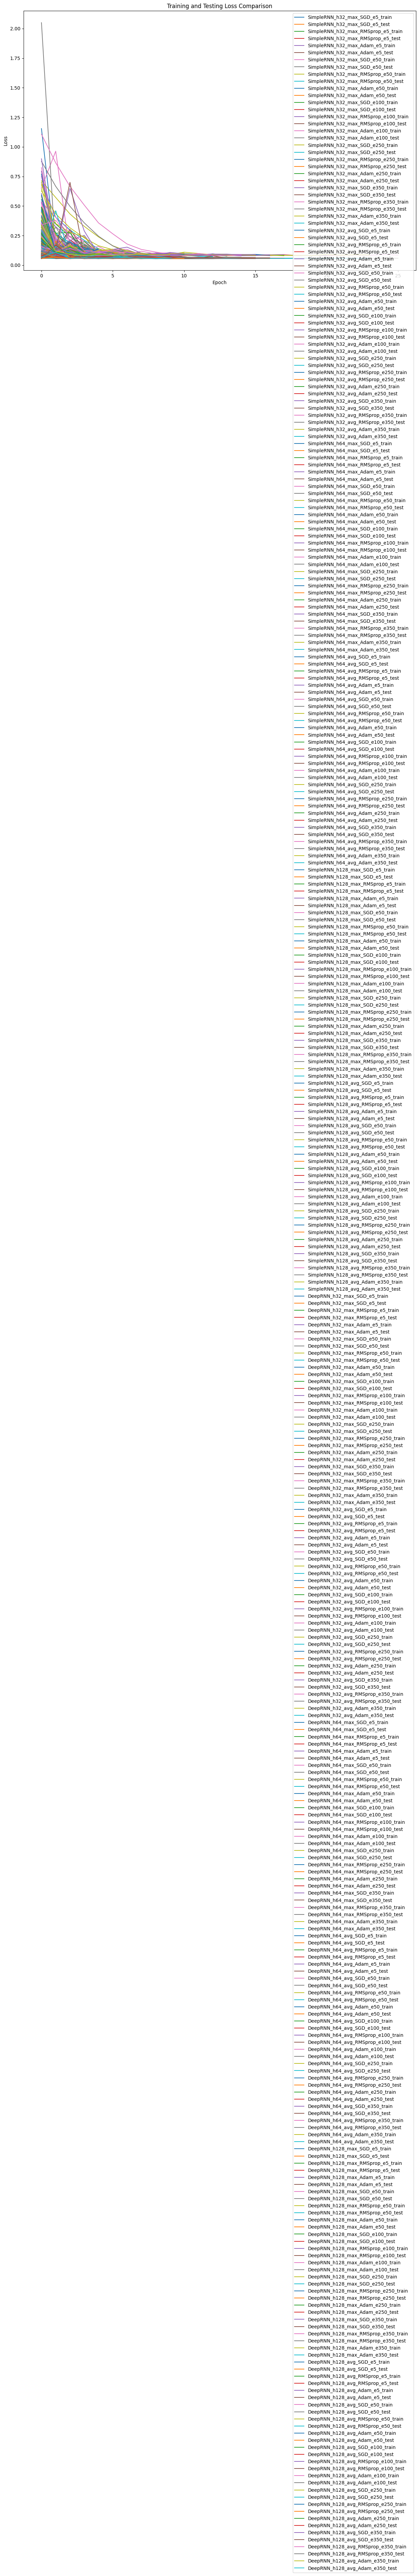

In [17]:
# Plot results
plt.figure(figsize=(15, 10))
for config, metrics in results.items():
    plt.plot(metrics['train_losses'], label=f'{config}_train')
    plt.plot(metrics['test_losses'], label=f'{config}_test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss Comparison')
    plt.legend() # Corrected indentation
plt.show() # Corrected indentation to be outside the loop